### Import and Load model

In [2]:
import time
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from scipy.stats import entropy
from tqdm import tqdm

import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn

from utils.plots import plot_pr,plot_roc, plot_dist, plot_violin
from utils.metircs import accuracy,mutual_info,nll, ece
from utils.visual import ProgressMeter, AverageMeter, Summary
from data_utils.get_datasets import get_dataset
from model_utils.get_models import get_model
from uncertainty.mc_dropout import mc_dropout_predict
from uncertainty.test_time_aug import test_time_aug_predict
from uncertainty.deep_ensemble import deep_ensembel_predict,EnsembleModel
from uncertainty.baseline_softmax import baseline_softmax_predict
from uncertainty.bnn_svi import bnn_svi_predict
from adversarial.adversarial_attack import fgsm_attack, pgd_attack

In [3]:
device = torch.device('cuda:0')
model = get_model("vgg16", 10, use_torchvision=False)
model = model.to(device)
model.eval()
checkpoint = torch.load("../saved_models/deterministic/vgg16/2023_11_24_19_22_52/vgg16_best_model_93.95.pth",map_location=device)
model.load_state_dict(checkpoint['state_dict'])

use private models...


<All keys matched successfully>

In [4]:
summary(model,(3,32,32))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [5]:
#random Gaussian noise fed into an image classifier gives a “prediction confidence” or predicted class probability of 91%
noise = torch.randn(64,3,32,32).to(device)
prob = torch.softmax(model(noise), axis=1)
print(torch.max(prob,axis=1))

torch.return_types.max(
values=tensor([0.4941, 0.3752, 0.3833, 0.4007, 0.5256, 0.3697, 0.4449, 0.5589, 0.3367,
        0.5244, 0.3981, 0.2777, 0.5872, 0.4766, 0.5311, 0.3894, 0.3512, 0.3834,
        0.3732, 0.4978, 0.2882, 0.4808, 0.4396, 0.3182, 0.3867, 0.3654, 0.4578,
        0.4602, 0.3782, 0.3095, 0.3691, 0.3344, 0.3456, 0.4235, 0.4206, 0.4652,
        0.3927, 0.3712, 0.3752, 0.5417, 0.4539, 0.6303, 0.4073, 0.4963, 0.3920,
        0.4531, 0.4136, 0.3937, 0.4100, 0.3723, 0.6327, 0.4730, 0.4341, 0.3647,
        0.4942, 0.3378, 0.3432, 0.3942, 0.4703, 0.4285, 0.5095, 0.4384, 0.3637,
        0.4042], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4, 2, 4, 2, 4, 4, 2, 6, 2, 4, 4, 6, 4, 6, 4, 2, 4, 4, 4, 4, 4, 6, 6, 2,
        4, 4, 2, 6, 6, 2, 2, 4, 2, 4, 4, 4, 4, 6, 2, 6, 4, 6, 6, 2, 6, 2, 4, 4,
        2, 2, 4, 4, 4, 4, 4, 6, 4, 6, 6, 6, 6, 6, 4, 4], device='cuda:0'))


In [6]:
%reload_ext autoreload
%autoreload 2

### Baseline softmax

In [7]:
datanames = [ "cifar10", "mnist","fashionmnist","svhn"]
probs_list = []
targets_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
        [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
        ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)
    
    probs ,targets= baseline_softmax_predict(val_loader, model, device)
    probs_list.append(probs.cpu().detach().numpy())
    targets_list.append(targets.cpu().detach().numpy())

 * Time 0.002 Acc@1 93.950
 * Time 0.002 Acc@1 4.930
 * Time 0.002 Acc@1 9.270
 * Time 0.002 Acc@1 11.371


#### maxpsclassified

In [8]:
cifar10_probs = probs_list[0]
cifar10_target = targets_list[0]
print(cifar10_probs.shape)

(10000, 10)


In [9]:
cifar10_pred = np.argmax(cifar10_probs,axis=1)
labels = (cifar10_pred == cifar10_target).astype(int)#正确分类标为1，误分类标为0
maxp = np.max(cifar10_probs,axis=1)
random_pred = np.random.rand(labels.shape[0])

In [10]:
succ_maxp_mean = maxp[labels==1].mean()
err_maxp_mean = maxp[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均预测概率:{succ_maxp_mean:.3f}\n错误分类样本数{(1-labels).sum()},平均预测概率:{err_maxp_mean:.3f}")

正确分类样本数9395,平均预测概率:0.867
错误分类样本数605,平均预测概率:0.600


In [11]:
ent = entropy(cifar10_probs,axis=1)

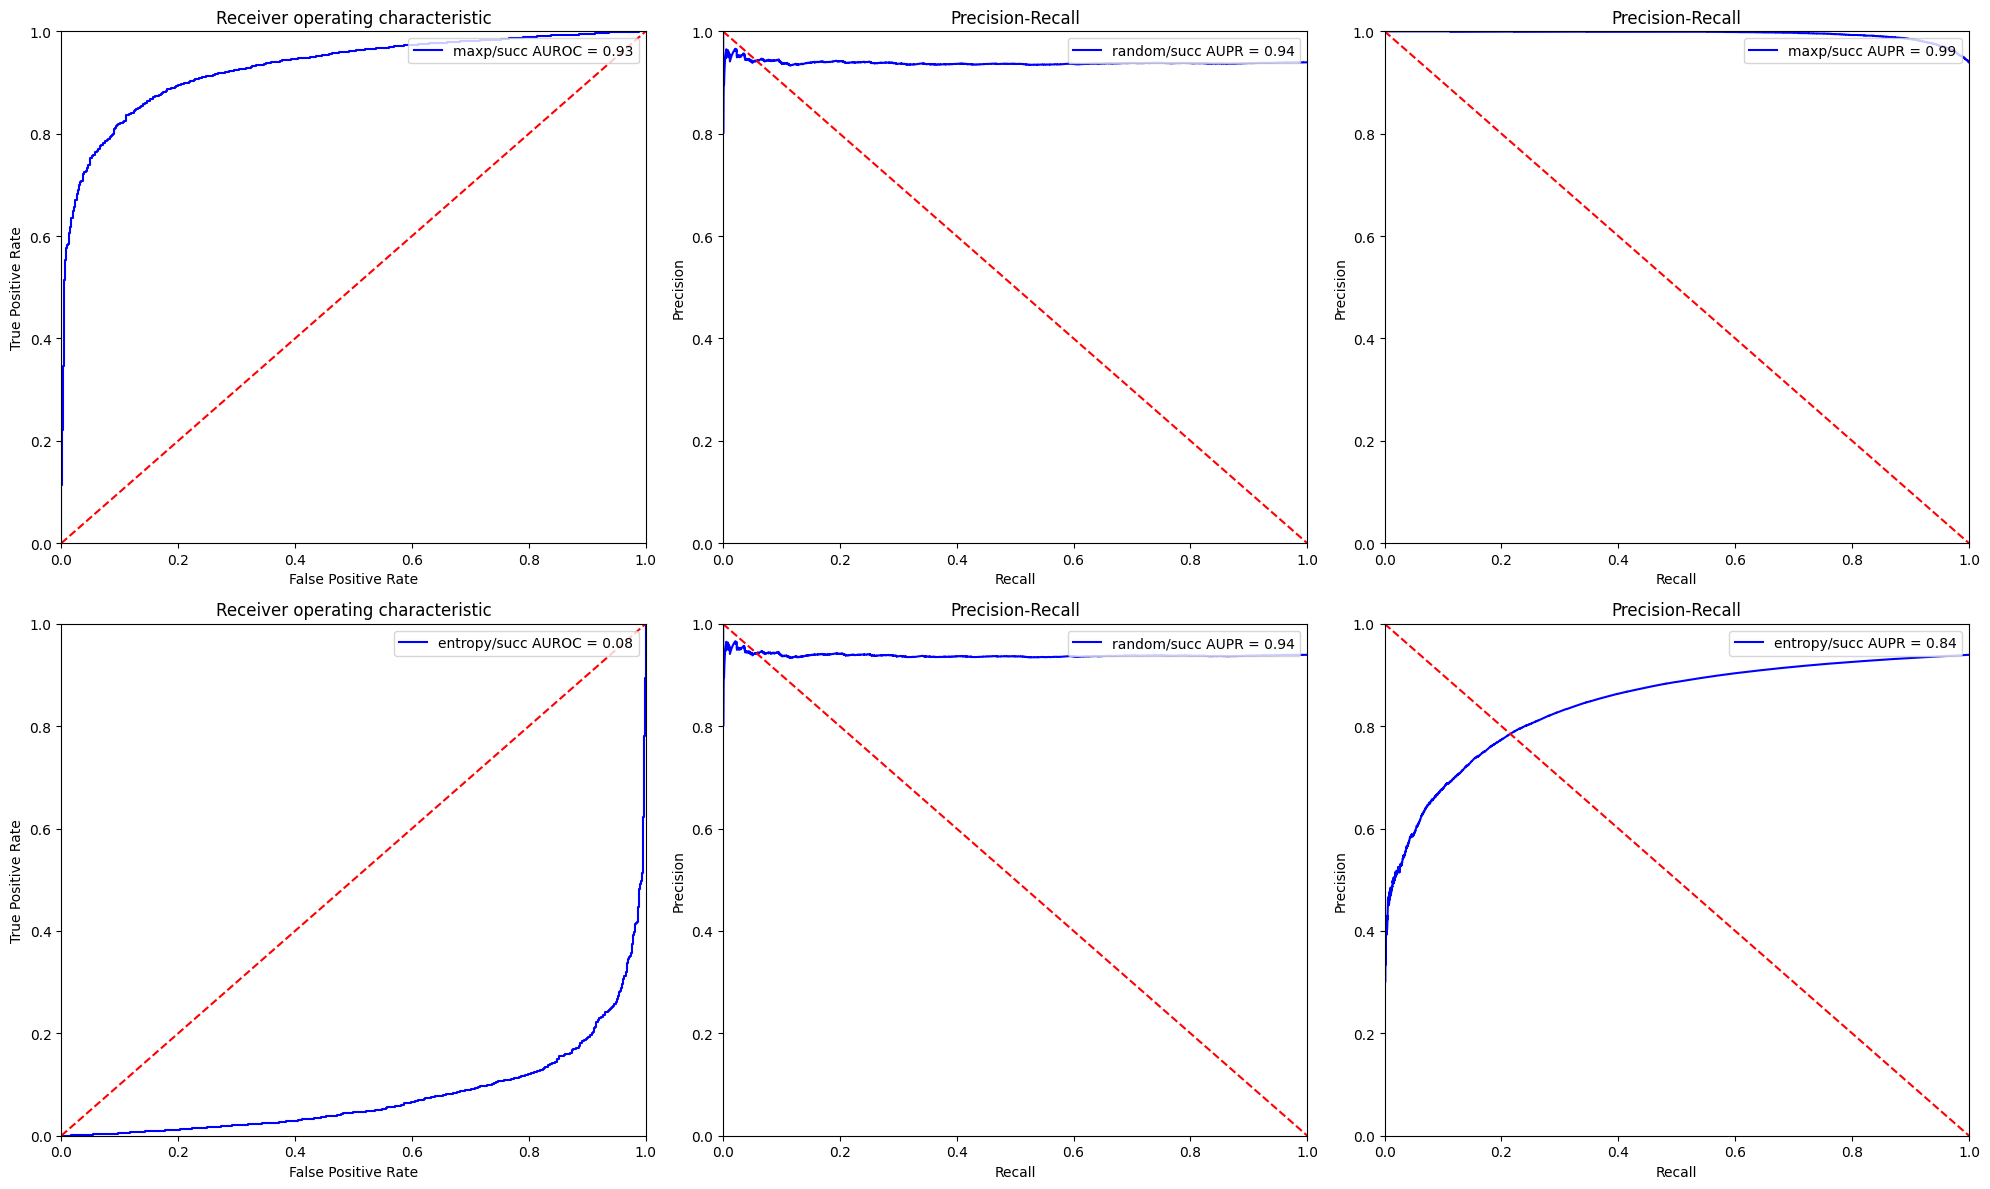

In [12]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels,maxp,"maxp/succ")
plot_pr(axes[0][1],labels,random_pred,"random/succ")
plot_pr(axes[0][2],labels,maxp,"maxp/succ")
plot_roc(axes[1][0], labels,ent,"entropy/succ")
plot_pr(axes[1][1],labels,random_pred,"random/succ")
plot_pr(axes[1][2],labels,ent,"entropy/succ")
plt.tight_layout()

In [13]:
#IND样本视为负样本， mnist样本视为正样本
labels2 = (cifar10_pred != cifar10_target).astype(int)#正确分类标为1，误分类标为0
maxp2 =  -maxp
ent2 = -ent
random_pred2 = -random_pred

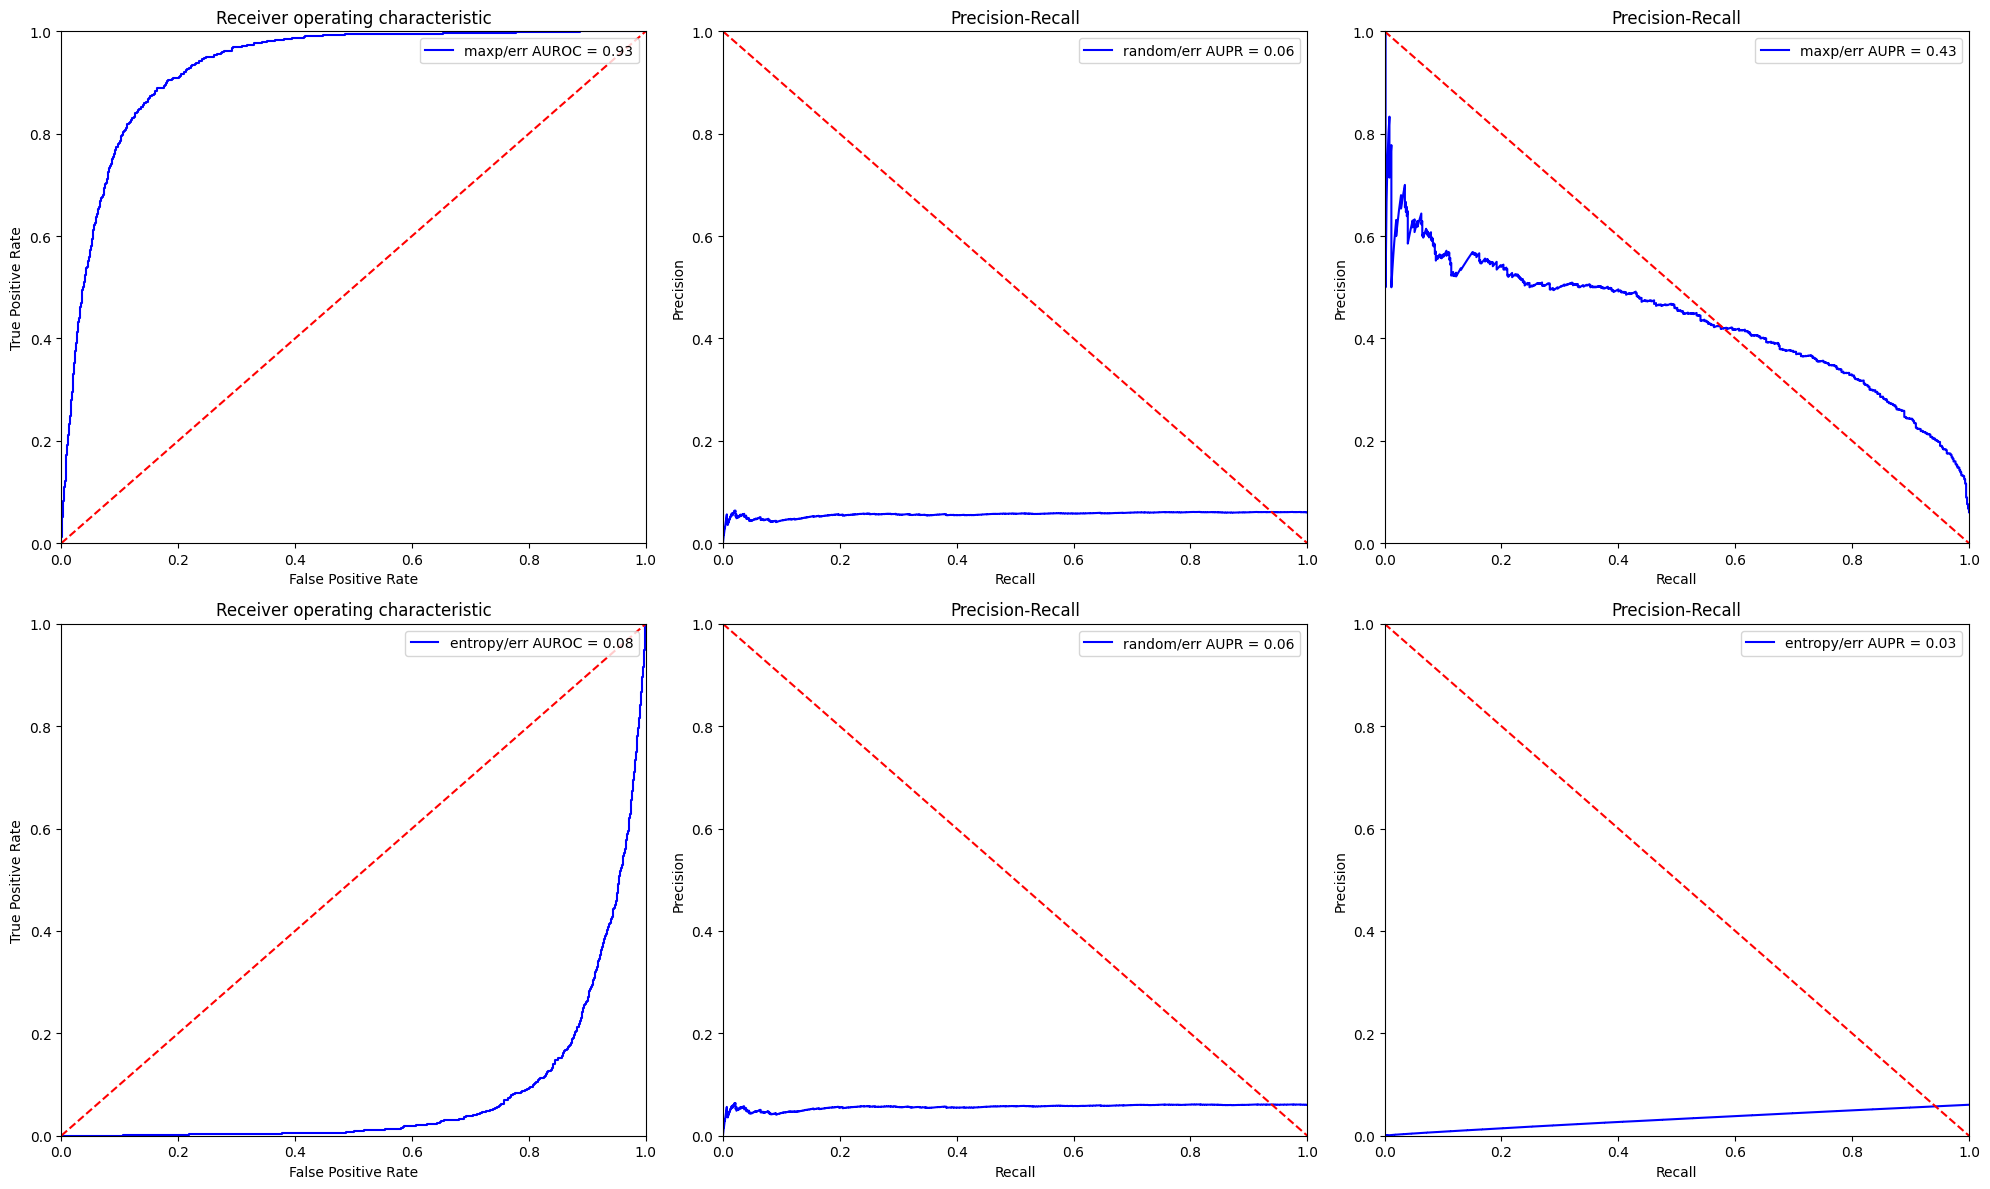

In [14]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels2,maxp2,"maxp/err")
plot_pr(axes[0][1],labels2,random_pred2,"random/err")
plot_pr(axes[0][2],labels2,maxp2,"maxp/err")
plot_roc(axes[1][0], labels2,ent2,"entropy/err")
plot_pr(axes[1][1],labels2,random_pred2,"random/err")
plot_pr(axes[1][2],labels2,ent2,"entropy/err")
plt.tight_layout()

#### OOD

In [15]:
maxp_list = []
for i, probs in enumerate(probs_list):
    maxp_list.append(np.max(probs,axis=1))

In [16]:
ent_list = []
for i, probs in enumerate(probs_list):
    ent = entropy(probs,axis=1)
    ent_list.append(ent)

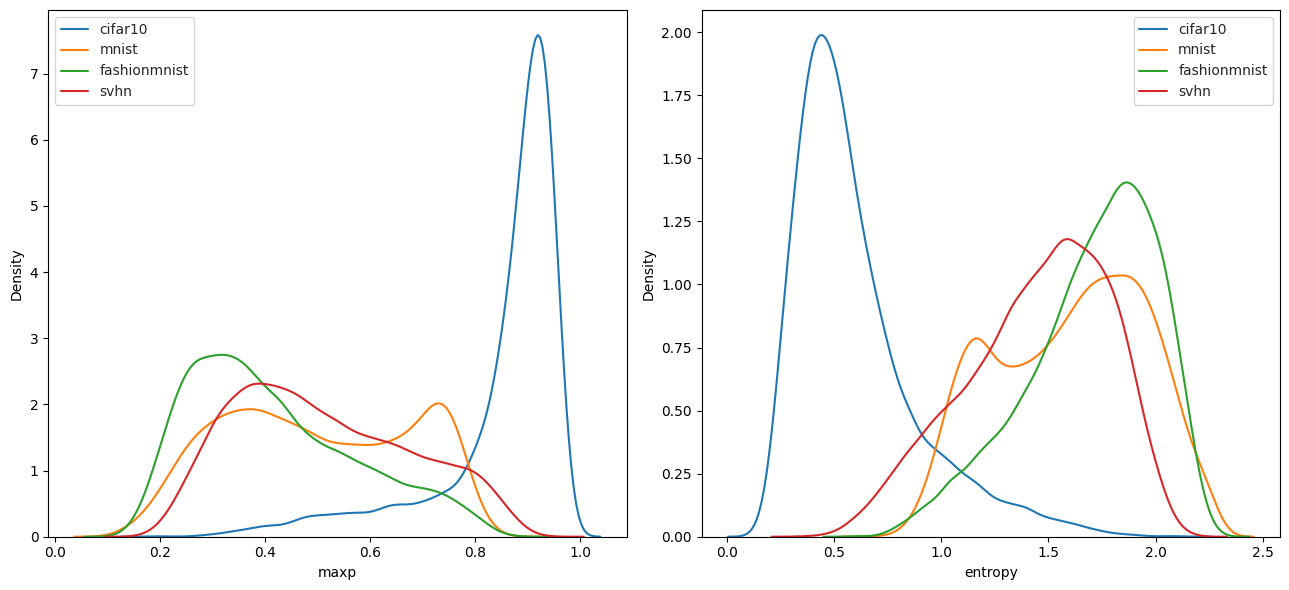

In [17]:
#绘制maxp,熵的分布
fig, axes = plt.subplots(1,2, figsize=(13, 6))
plot_dist(axes[0],maxp_list,datanames,"maxp")
plot_dist(axes[1], ent_list,datanames,"entropy")
plt.tight_layout()

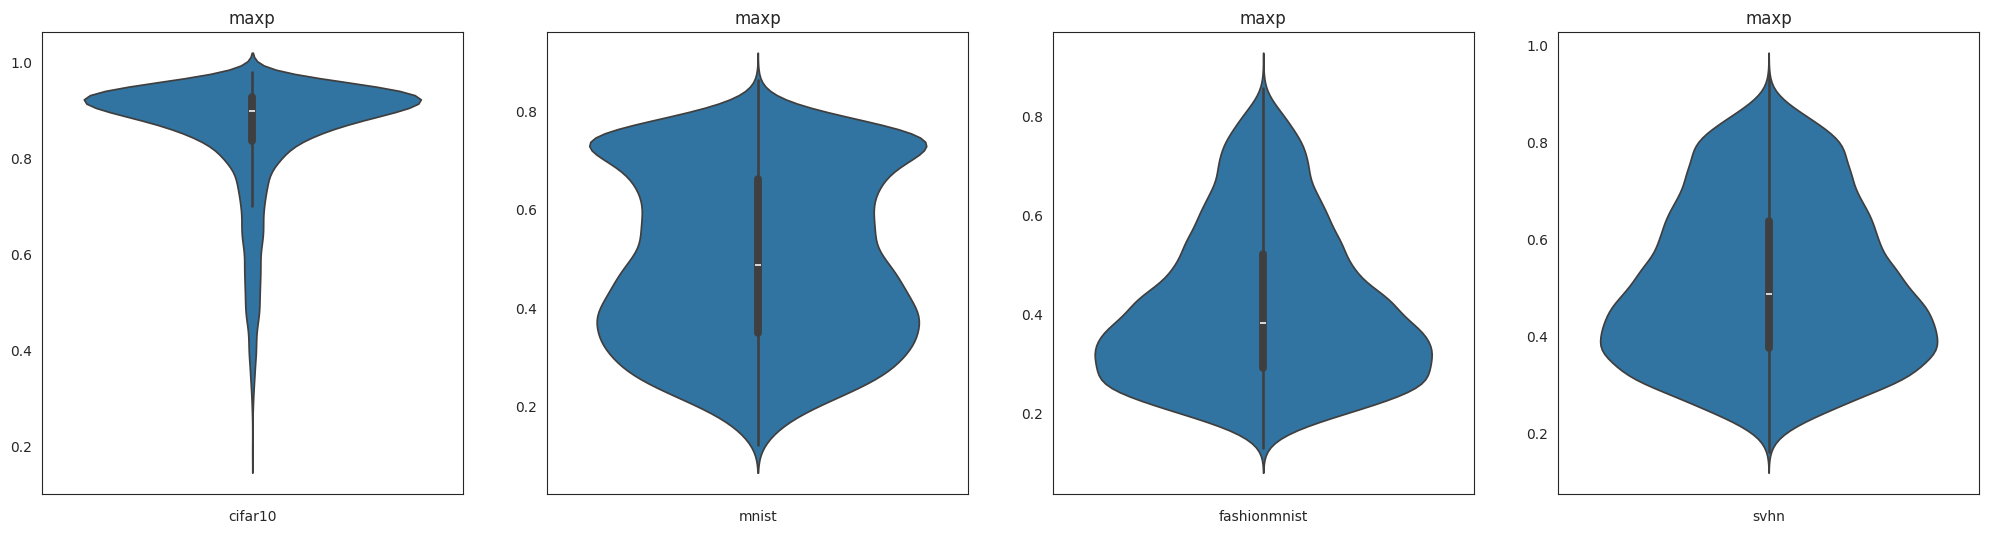

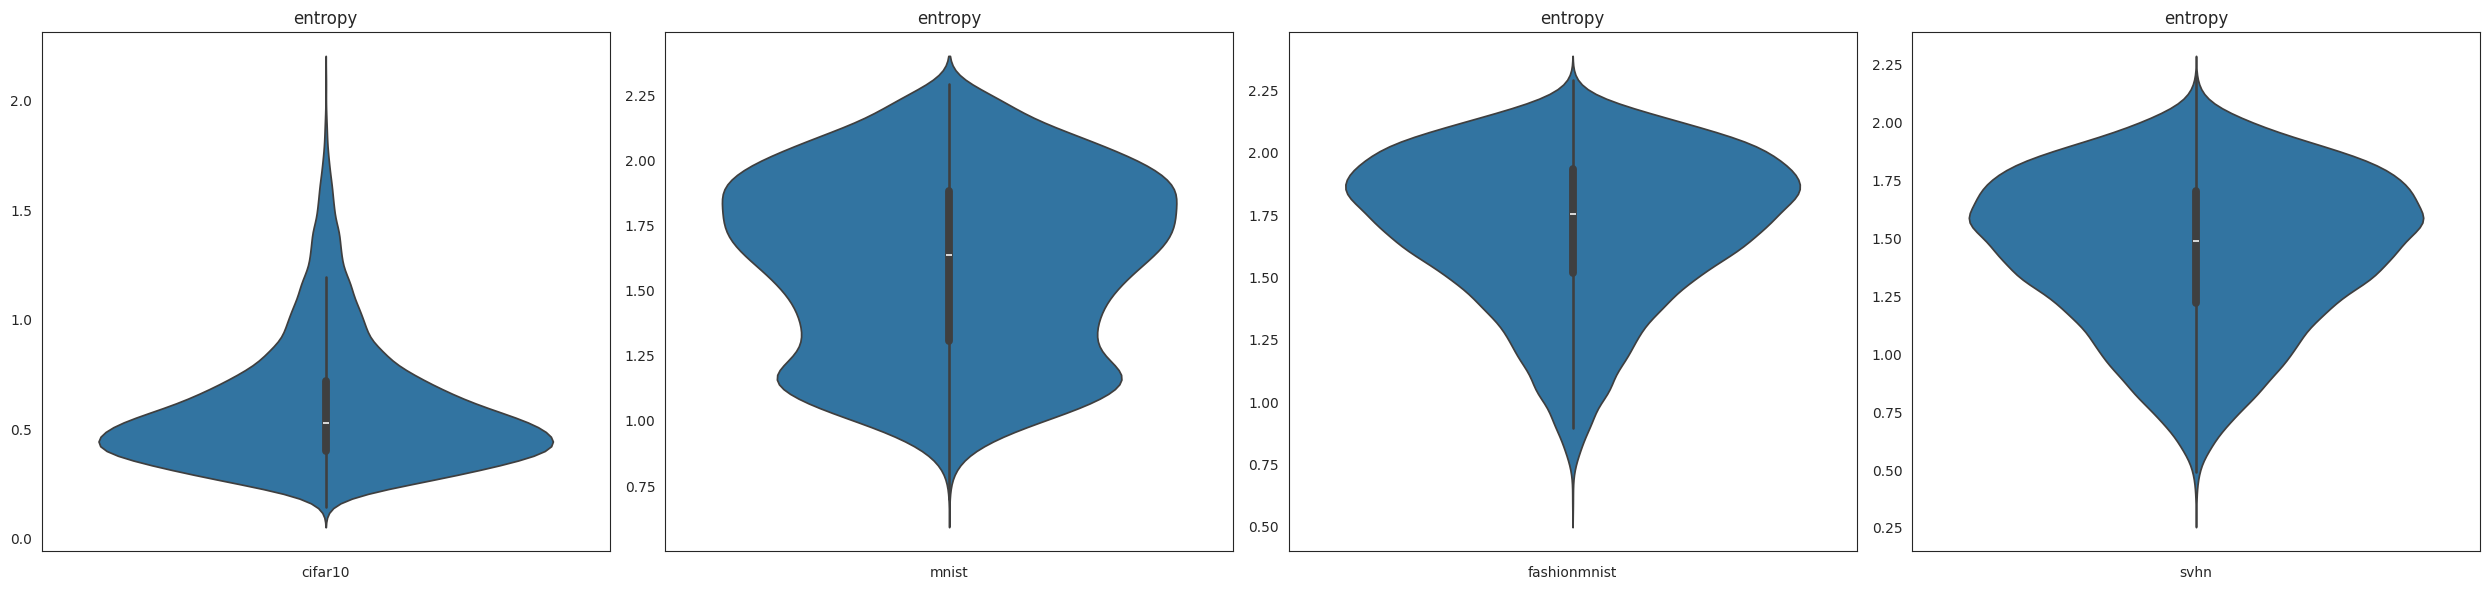

In [18]:
#绘制小提琴图
fig, axes = plt.subplots(1,4, figsize=(25, 6))
plot_violin(axes,maxp_list,datanames,"maxp")
fig, axes = plt.subplots(1,4, figsize=(25, 6))
plot_violin(axes, ent_list,datanames,"entropy")
plt.tight_layout()

In [19]:
#IND样本视为正样本， mnist样本视为负样本
ood_idx=1
print(f"cifar10 test nums:{len(maxp_list[0])},mnist test nums:{len(maxp_list[1])}")
labels = [1]*len(maxp_list[0])+[0]*len(maxp_list[ood_idx])
maxp = np.concatenate([maxp_list[0],maxp_list[ood_idx]])*-1
ent = np.concatenate([ent_list[0],ent_list[ood_idx]])*-1
random_pred = np.random.rand(len(labels))*-1

cifar10 test nums:10000,mnist test nums:10000


In [20]:
len(labels)
ent.shape

(20000,)

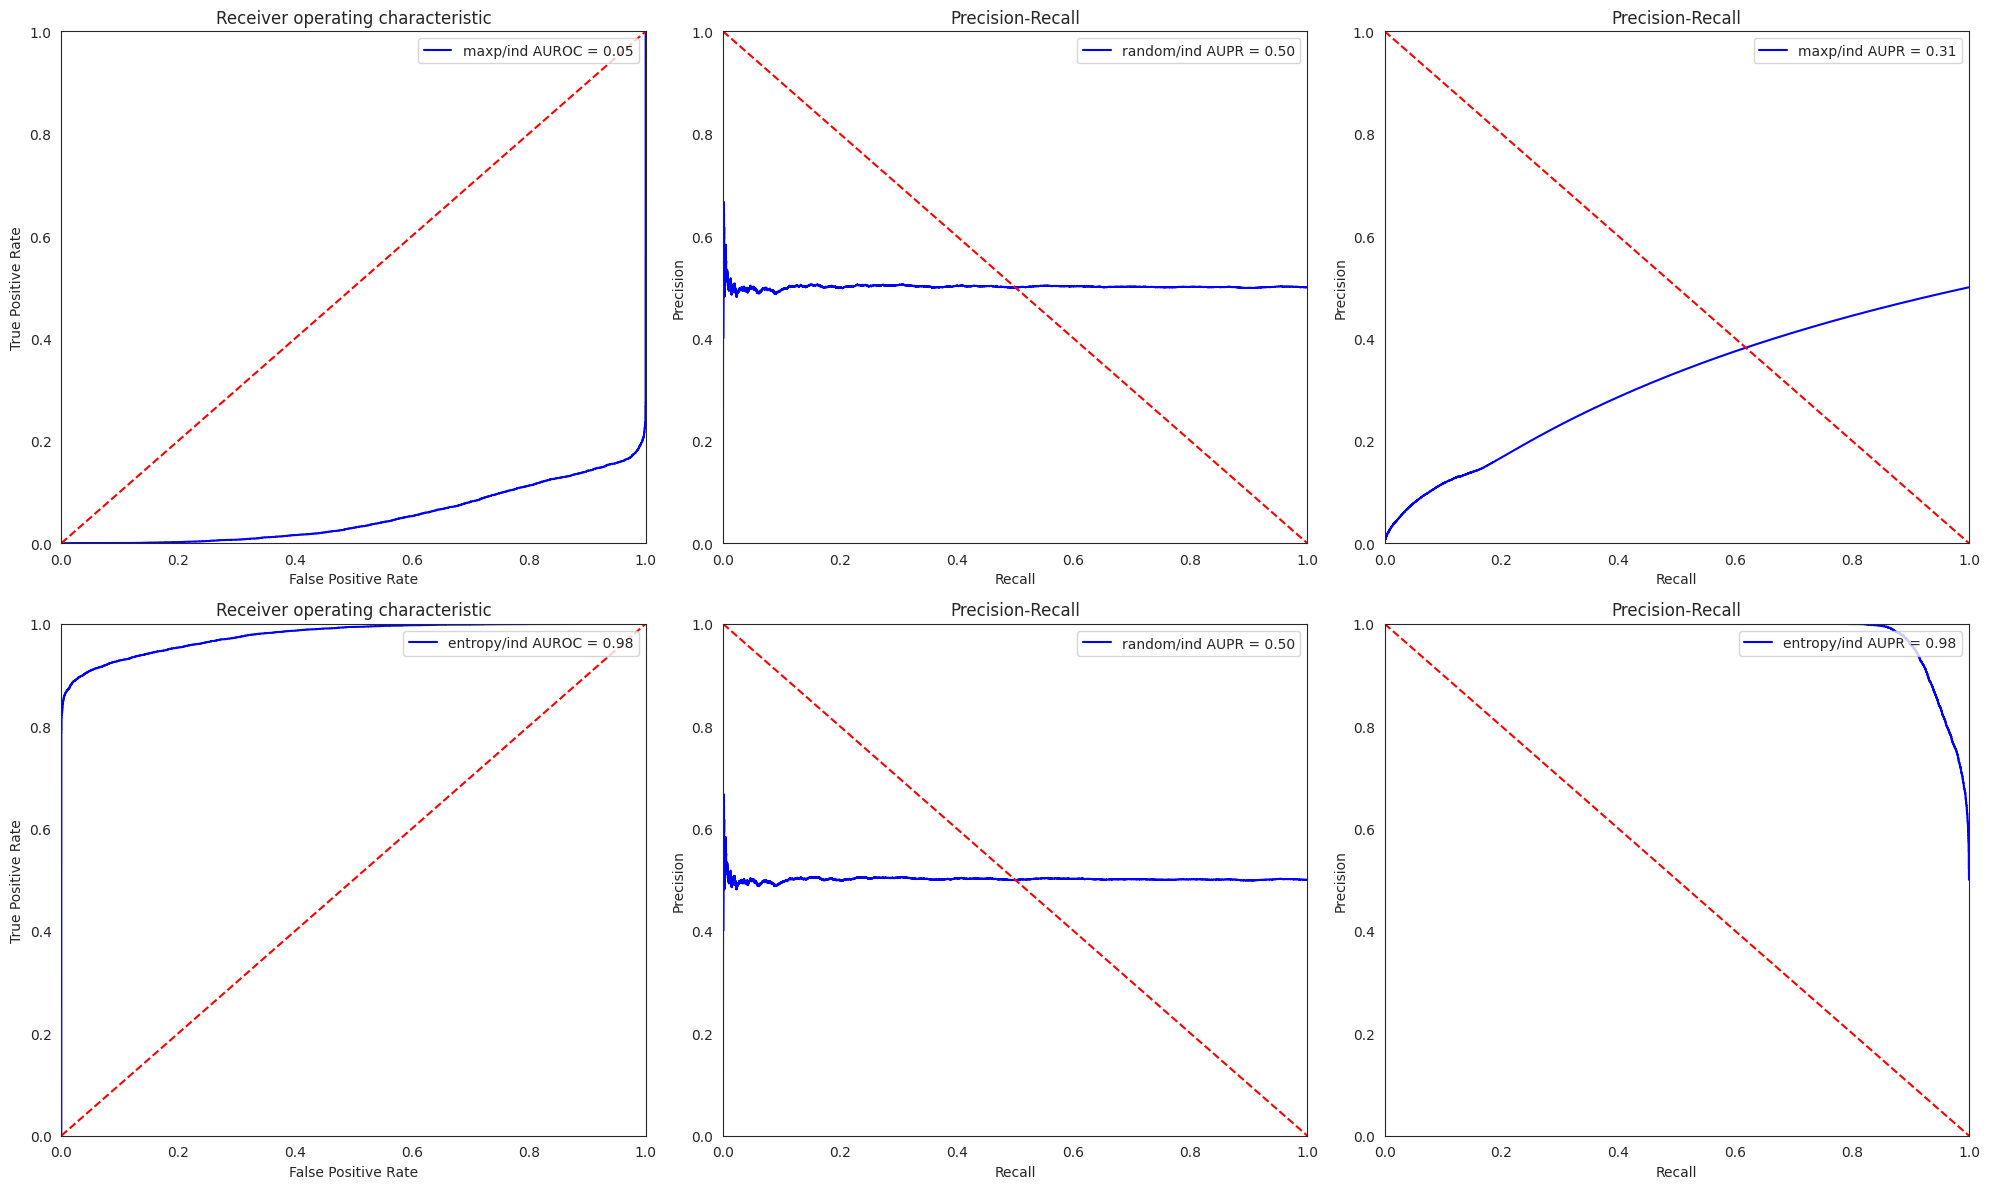

In [21]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels,maxp,"maxp/ind")
plot_pr(axes[0][1],labels,random_pred,"random/ind")
plot_pr(axes[0][2],labels,maxp,"maxp/ind")
plot_roc(axes[1][0], labels,ent,"entropy/ind")
plot_pr(axes[1][1],labels,random_pred,"random/ind")
plot_pr(axes[1][2],labels,ent,"entropy/ind")
plt.tight_layout()

In [22]:
#IND样本视为负样本， mnist样本视为正样本
labels2 = [0]*len(maxp_list[0])+[1]*len(maxp_list[1])
maxp2 =  -maxp
ent2 = -ent
random_pred2 = -random_pred

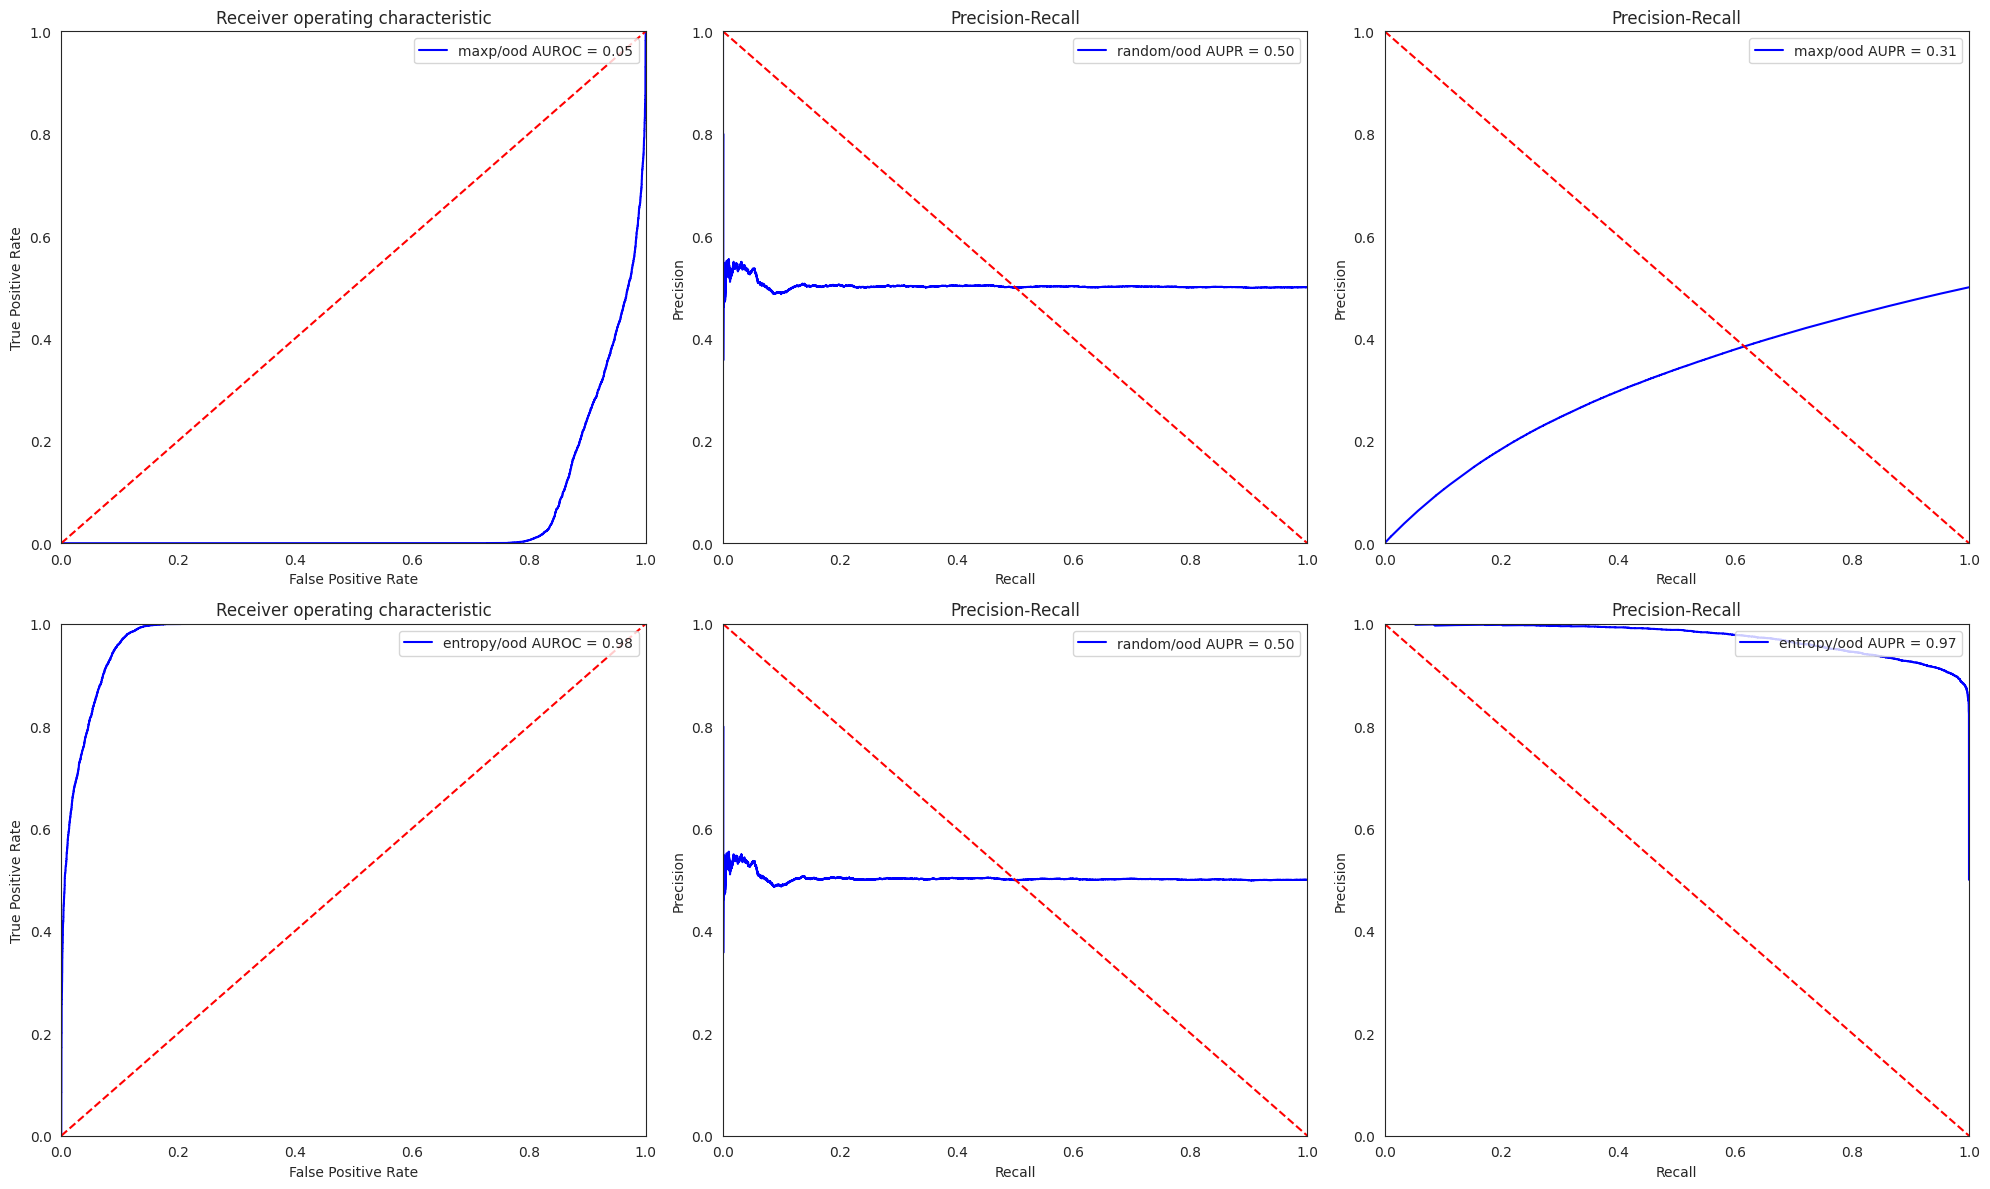

In [23]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels2,maxp2,"maxp/ood")
plot_pr(axes[0][1],labels2,random_pred2,"random/ood")
plot_pr(axes[0][2],labels2,maxp2,"maxp/ood")
plot_roc(axes[1][0], labels2,ent2,"entropy/ood")
plot_pr(axes[1][1],labels2,random_pred2,"random/ood")
plot_pr(axes[1][2],labels2,ent2,"entropy/ood")
plt.tight_layout()

#### advasarial attack

In [24]:
val_transform = transforms.Compose(
        [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
        ]
    )
_, val_dataset = get_dataset("cifar10","../data",None,val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True)

In [ ]:
adv_probs_list = []
origin_probs_list = []
method = "pgd"
epsilon = 0.01
correct = 0
err = 0
num_correct=0
for images, targets in tqdm(val_loader):
    images, targets = images.to(device), targets.to(device)
    origin_prob = torch.softmax(model(images), axis=1)
    clean_prob, origin_pred = torch.max(origin_prob,axis=1)
    # num_correct += (origin_pred == targets).sum().item()
    if origin_pred.item() != targets.item():
        err += 1
        continue

    if method == "fgsm":
        perturbed_images = fgsm_attack(model, images, targets, epsilon)
    elif method == "pgd":
        perturbed_images = pgd_attack(model, images, targets, epsilon)

    adv_prob = torch.softmax(model(perturbed_images), axis=1)
    _, adv_pred = adv_prob.max(1, keepdim=True)
    adv_probs_list.append(adv_prob.cpu().detach().numpy())
    origin_probs_list.append(origin_prob.cpu().detach().numpy())

    if adv_pred.item() == targets.item():
        correct += 1

adv_acc = correct/float(len(val_loader)-err)
print(
    f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(val_loader)} = {adv_acc}\tIgnore err = {err}")

  1%|▊                                                                                          | 88/10000 [00:19<41:54,  3.94it/s]

In [ ]:
adv_probs = np.concatenate(adv_probs_list,axis=0)
origin_probs = np.concatenate(origin_probs_list,axis=0)
print(origin_probs.shape)
print(f"原始样本平均预测概率{np.max(origin_probs,axis=1).mean()},对抗样本平均预测概率{np.max(adv_probs,axis=1).mean()}")

In [ ]:
maxp_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    maxp_list.append(np.max(probs,axis=1))

In [ ]:
ent_list = []
for i, probs in enumerate([origin_probs,adv_probs]):
    ent = entropy(probs,axis=1)
    ent_list.append(ent)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(13, 6))
plot_dist(axes[0],maxp_list,["original","advasarial"],"maxp")
plot_dist(axes[1], ent_list,["original","advasarial"],"entropy")
plt.tight_layout()

In [ ]:
#原始样本视为正样本， 攻击样本视为负样本
labels = [1]*len(maxp_list[0])+[0]*len(maxp_list[1])
maxp = np.concatenate([maxp_list[0],maxp_list[1]])*-1
ent = np.concatenate([ent_list[0],ent_list[1]])*-1
random_pred = np.random.rand(len(labels))*-1

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels,maxp,"maxp/origin")
plot_pr(axes[0][1],labels,random_pred,"random/origin")
plot_pr(axes[0][2],labels,maxp,"maxp/origin")
plot_roc(axes[1][0], labels,ent,"entropy/origin")
plot_pr(axes[1][1],labels,random_pred,"random/origin")
plot_pr(axes[1][2],labels,ent,"entropy/origin")
plt.tight_layout()

In [ ]:
#原始样本视为正样本， 攻击样本视为负样本
labels2 = [0]*len(maxp_list[0])+[1]*len(maxp_list[1])
maxp2 =  -maxp
ent2 = -ent
random_pred2 = -random_pred

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
plot_roc(axes[0][0], labels2,maxp2,"maxp/adv")
plot_pr(axes[0][1],labels2,random_pred2,"random/adv")
plot_pr(axes[0][2],labels2,maxp2,"maxp/adv")
plot_roc(axes[1][0], labels2,ent2,"entropy/adv")
plot_pr(axes[1][1],labels2,random_pred2,"random/adv")
plot_pr(axes[1][2],labels2,ent2,"entropy/adv")
plt.tight_layout()